# [Draft] Data analysis

In [1]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp

plt.rcParams["font.family"] = "monospace"

In [2]:
NUM_DEVICES = 8
BATCH_PER_DEVICE = 1
SEQ_LEN = 64 * 1024

STEP_PATTERN = r"step:([0-9]+)/([0-9]+)"
VAL_LOSS_PATTERN = r"val_loss:([0-9.]+)"
TRAIN_TIME_PATTERN = r"train_time:([0-9]+)ms"

## Prepare data

In [10]:
IMAGES_SAVE_PATH = "."

old_record_filenames = [
    "../111924_FlexAttention/8384493d-dba9-4991-b16b-8696953f5e6d.txt",
    "c4914481-6b32-4a3a-a449-41e2c595c940.txt",
    "a9d67362-5c57-4194-936f-2f2c2795b75f.txt",
    "7807d03c-7198-483e-a472-1fcb99d90ea2.txt",
]
new_record_filenames = [
    "44ad04d7-f115-4cb8-a70c-b8b09da600a3.txt",
    "63bd09f5-1c19-4f79-b0eb-31bdffabed2e.txt",
    "0737e5d1-5bf3-476a-98f4-c3f7a08fde0a.txt",
    "1da8bcf8-3280-46c3-b6d0-6811da564e33.txt",
]
new_record_filenames2 = [
    "6ddabdd4-6143-48b3-822c-4503d982ce1b.txt",
    "f11e3b5e-59a1-4e41-b594-152003218ba1.txt",
    "4c7c3d84-906a-4751-b76b-e039aeab4ec9.txt",
    "6d7f7872-9dee-4640-bbbb-3e566e5c023f.txt",
]
new_record_filenames3 = [
    "d6286d13-5313-44d9-bc72-b8e3e272e4de.txt",
    "a101ae21-86e8-4c4d-b8c6-51222d5591cc.txt",
    "2810e887-1e75-4789-a517-1dafeab04f47.txt",
    "344c3069-737a-423a-aca2-8f28cb829c3a.txt",
    # "aba89436-affb-474a-a63c-909ed3cce27c.txt",
    # "20285275-8b39-420c-ad12-e32a2ab5b790.txt",
    # "658e9dc2-2f67-4139-b4ec-7558bbdad82b.txt",
    # "c319d71b-70d8-4673-bf68-14853d43fdda.txt",
    # "eb34e20c-85d4-4d5b-9cc6-b4754d7e0aac.txt",
]
test_filenames = [
    "c9c10091-c5ac-4f64-af30-a21e815f675b.txt",
    "72d09161-8ce1-4584-8af9-b04f0351b280.txt",
]
all_filenames = [
    old_record_filenames,
    new_record_filenames,
    new_record_filenames2,
    new_record_filenames3,
    test_filenames,
]
filenames = (
    old_record_filenames
    + new_record_filenames
    + new_record_filenames2
    + new_record_filenames3
    + test_filenames
)

old_record_labels = [
    "11/19 record, 8xH100",
    "11/19 record, 4xH100",
    "11/19 record, 4xH100",
    "11/19 record, 4xH100",
]
new_record_labels = [
    "UNet Att. Vs, 4xA100",
    "UNet Att. Vs, 4xH100",
    "UNet Att. Vs, 4xH100",
    "Unet Att. Vs, 4xH100",
]
new_record_labels2 = [
    "UNet Att. Vs;-30steps, 4xH100",
    "UNet Att. Vs;-30steps, 4xH100",
    "UNet Att. Vs;-30steps, 4xH100",
    "UNet Att. Vs;-30steps, 4xH100",
]
new_record_labels3 = [
    "UNet Att. Vs;-40steps, 4xH100",
    "UNet Att. Vs;-40steps, 4xH100",
    "UNet Att. Vs;-40steps, 4xH100",
    "UNet Att. Vs;-40steps, 4xH100",
    # "UNet Att. Vs;-50steps, 8xH100",
    # "UNet Att. Vs;-50steps;-15cooldown, 8xH100",
    # "UNet Att. Vs;-40steps;-15cooldown, 4xH100",
    # "UNet Att. Vs+GlobalLocalAtt;-40steps, 4xH100",
    # "Delta Att. Vs, 4xH100",
]
test_record_labels = [
    "Global-Local Attention, 4xH100",
    "Global-Local Attention, 4xH100",
]
labels = (
    old_record_labels
    + new_record_labels
    + new_record_labels2
    + new_record_labels3
    + test_record_labels
)

color_palettes = [
    # sns.dark_palette("#69d", n_colors=len(old_record_filenames)),
    ["Blue" for _ in old_record_filenames],
    # sns.color_palette("YlOrBr", n_colors=len(new_record_filenames)),
    ["Red" for _ in new_record_filenames],
    # sns.color_palette("crest", n_colors=len(new_record_filenames2)),
    ["Green" for _ in new_record_filenames2],
    # sns.color_palette("Purples", n_colors=len(test_filenames)),
    ["Yellow" for _ in new_record_filenames3],
    ["Purple" for _ in test_filenames],
]

In [11]:
files = [open(filename, "r").readlines() for filename in filenames]

In [12]:
steps = [[] for _ in range(len(files))]
val_losses = [[] for _ in range(len(files))]
train_times = [[] for _ in range(len(files))]
train_times_min = [[] for _ in range(len(files))]
train_tokens = [[] for _ in range(len(files))]
for idx, file in enumerate(files):
    for line in file:
        if line.startswith("step:") and "val_loss:" in line:
            step = re.search(STEP_PATTERN, line).group(1)
            val_loss = re.search(VAL_LOSS_PATTERN, line).group(1)
            train_time = re.search(TRAIN_TIME_PATTERN, line).group(1)
            steps[idx].append(int(step))
            val_losses[idx].append(float(val_loss))
            train_times[idx].append(float(train_time))
    steps[idx] = np.array(steps[idx])
    val_losses[idx] = np.array(val_losses[idx])
    train_times[idx] = np.array(train_times[idx])
    train_times_min[idx] = train_times[idx] / 1000 / 60
    train_tokens[idx] = NUM_DEVICES * BATCH_PER_DEVICE * SEQ_LEN * steps[idx]

In [13]:
step_avg = [train_times[i][-1] / steps[i][-1] for i in range(len(files))]
final_val_losses = [val_losses[i][-1] for i in range(len(files))]

## T-Tests

In [14]:
n = len(old_record_filenames)
m = len(new_record_filenames)
k = len(new_record_filenames2)
l = len(new_record_filenames3)
s = len(test_filenames)
slices = [slice(0, n), slice(n, n+m), slice(n+m, n+m+k), slice(n+m+k, n+m+k+l), slice(n+m+k+l, n+m+k+l+s)]
for i in range(len(slices)):
    print(np.mean(final_val_losses[slices[i]]))
for i in range(len(slices)):
    t, p = ttest_1samp(final_val_losses[slices[i]], 3.28, alternative="less")
    if p < 0.05:
        print(f"[{labels[slices[i].start]:<30}]  p-value = {p:.4f}, reject null hypothesis; has lower final validation loss than baseline")
    else:
        print(f"[{labels[slices[i].start]:<30}]  p-value = {p:.4f}, not enough evidence to reject null hypothesis")

3.2801250000000004
3.273875
3.2737499999999997
3.277275
3.2818500000000004
[11/19 record, 8xH100          ]  p-value = 0.5495, not enough evidence to reject null hypothesis
[UNet Att. Vs, 4xA100          ]  p-value = 0.0453, reject null hypothesis; has lower final validation loss than baseline
[UNet Att. Vs;-30steps, 4xH100 ]  p-value = 0.0168, reject null hypothesis; has lower final validation loss than baseline
[UNet Att. Vs;-40steps, 4xH100 ]  p-value = 0.0518, not enough evidence to reject null hypothesis
[Global-Local Attention, 4xH100]  p-value = 0.8109, not enough evidence to reject null hypothesis


In [15]:
n = len(old_record_filenames)
m = len(new_record_filenames)
k = len(new_record_filenames2)
l = len(new_record_filenames3)
s = len(test_filenames)
slices = [slice(0, n), slice(n, n+m), slice(n+m, n+m+k), slice(n+m+k, n+m+k+l), slice(n+m+k+l, n+m+k+l+s)]
for i in range(len(slices)):
    for j in range(i+1, len(slices)):
        t, p = ttest_ind(final_val_losses[slices[i]], final_val_losses[slices[j]], alternative="greater", equal_var=False)
        if p < 0.05:
            print(f"p-value: {p:.4f}, reject null hypothesis; [{labels[slices[j].start]}] is better than [{labels[slices[i].start]}]")
        else:
            print(f"p-value: {p:.4f}, not reject null hypothesis; [{labels[slices[j].start]}] is not better than [{labels[slices[i].start]}]")

p-value: 0.0406, reject null hypothesis; [UNet Att. Vs, 4xA100] is better than [11/19 record, 8xH100]
p-value: 0.0115, reject null hypothesis; [UNet Att. Vs;-30steps, 4xH100] is better than [11/19 record, 8xH100]
p-value: 0.0542, not reject null hypothesis; [UNet Att. Vs;-40steps, 4xH100] is not better than [11/19 record, 8xH100]
p-value: 0.8127, not reject null hypothesis; [Global-Local Attention, 4xH100] is not better than [11/19 record, 8xH100]
p-value: 0.4841, not reject null hypothesis; [UNet Att. Vs;-30steps, 4xH100] is not better than [UNet Att. Vs, 4xA100]
p-value: 0.8599, not reject null hypothesis; [UNet Att. Vs;-40steps, 4xH100] is not better than [UNet Att. Vs, 4xA100]
p-value: 0.9768, not reject null hypothesis; [Global-Local Attention, 4xH100] is not better than [UNet Att. Vs, 4xA100]
p-value: 0.9292, not reject null hypothesis; [UNet Att. Vs;-40steps, 4xH100] is not better than [UNet Att. Vs;-30steps, 4xH100]
p-value: 0.9900, not reject null hypothesis; [Global-Local Att

## Plots

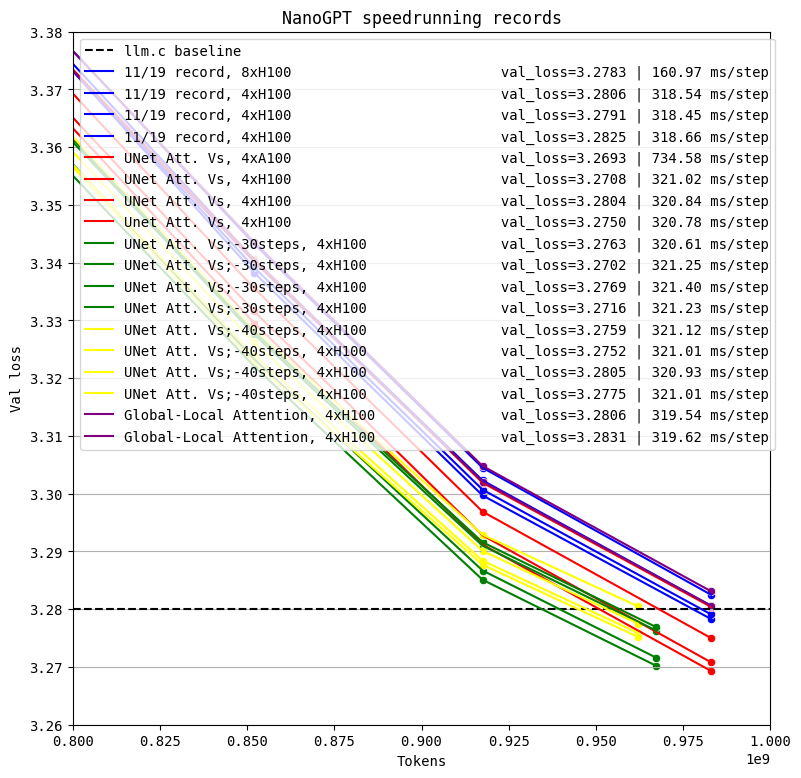

In [16]:
plt.figure(figsize=(9, 9))

sns.lineplot(x=np.linspace(0.8e9, 1.0e9, 100), y=[3.28]*100, linestyle="--", color="black", label="llm.c baseline")

offset = 0
for i, palette in enumerate(color_palettes):
    n = len(all_filenames[i])

    for idx, (tok, val_loss, step_avg_, final_val_loss, label) in enumerate(
        zip(
            train_tokens[offset:offset+n],
            val_losses[offset:offset+n],
            step_avg[offset:offset+n],
            final_val_losses[offset:offset+n],
            labels[offset:offset+n],
        )
    ):
        sns.scatterplot(x=tok, y=val_loss, linewidth=0.5, color=palette[idx])
        final_val_loss = f"{final_val_loss:.4f}"
        sns.lineplot(x=tok, y=val_loss, label=f"{label:<45}val_loss={final_val_loss} | {step_avg_:.2f} ms/step", color=palette[idx])

    offset += n

plt.title("NanoGPT speedrunning records")
plt.legend(loc="upper left")
plt.ylim(3.26, 3.38)
plt.yticks(np.linspace(3.26, 3.38, 13))
# plt.xlim(1.2e9, 1.6e9)
plt.xlim(0.8e9, 1.0e9)
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("Tokens")
plt.savefig(f"{IMAGES_SAVE_PATH}/nanogpt_speedrun_tokens.png")

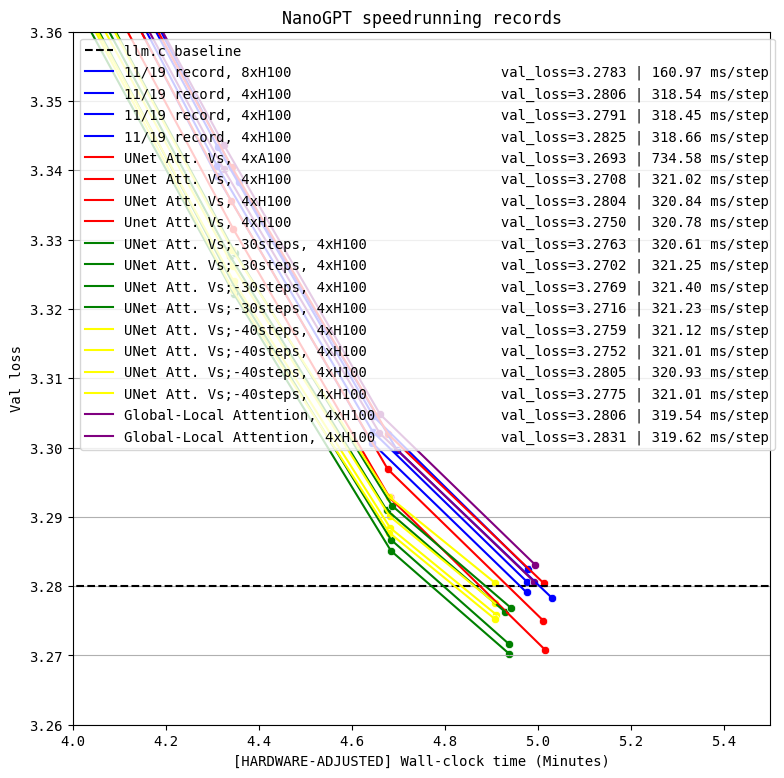

In [23]:
plt.figure(figsize=(9, 9))

sns.lineplot(x=np.linspace(0, 11, 100), y=[3.28]*100, linestyle="--", color="black", label="llm.c baseline")

offset = 0
for i, palette in enumerate(color_palettes):
    n = len(all_filenames[i])

    for idx, (train_times_min_, val_loss, step_avg_, final_val_loss, label) in enumerate(
        zip(
            train_times_min[offset:offset+n],
            val_losses[offset:offset+n],
            step_avg[offset:offset+n],
            final_val_losses[offset:offset+n],
            labels[offset:offset+n],
        )
    ):
        train_times_min_temp = train_times_min_ / 2 if "4xH100" in label else train_times_min_
        sns.scatterplot(x=train_times_min_temp, y=val_loss, linewidth=0.5, color=palette[idx])
        final_val_loss = f"{final_val_loss:.4f}"
        sns.lineplot(x=train_times_min_temp, y=val_loss, label=f"{label:<45}val_loss={final_val_loss} | {step_avg_:.2f} ms/step", color=palette[idx])

    offset += n

plt.title("NanoGPT speedrunning records")
plt.legend(loc="upper left")
plt.ylim(3.26, 3.36)
plt.yticks(np.linspace(3.26, 3.36, 11))
# plt.xticks(np.arange(0, 34, 2))
plt.xlim(4, 5.5)
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("[HARDWARE-ADJUSTED] Wall-clock time (Minutes)")
plt.savefig(f"{IMAGES_SAVE_PATH}/nanogpt_speedrun_wallclock.png")

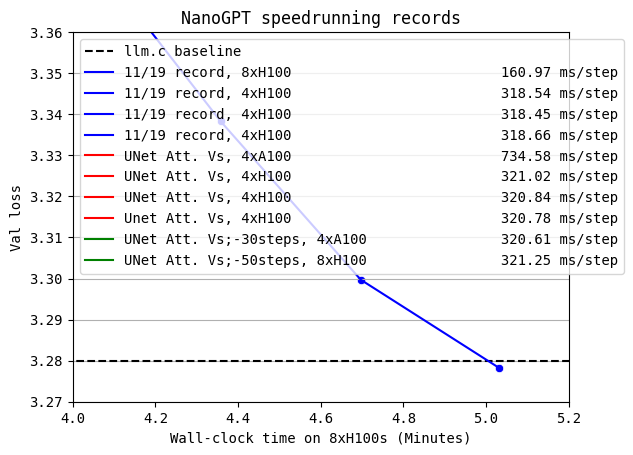

In [11]:
sns.lineplot(x=np.linspace(0, 24, 100), y=[3.28]*100, linestyle="--", color="black", label="llm.c baseline")

offset = 0
for i, palette in enumerate(color_palettes):
    n = len(all_filenames[i])

    for idx, (train_times_min_, val_loss, step_avg_, label) in enumerate(
        zip(
            train_times_min[offset:offset+n],
            val_losses[offset:offset+n],
            step_avg[offset:offset+n],
            labels[offset:offset+n],
        )
    ):
        sns.scatterplot(x=train_times_min_, y=val_loss, linewidth=0.5, color=palette[idx])
        sns.lineplot(x=train_times_min_, y=val_loss, label=f"{label:<45}{step_avg_:.2f} ms/step", color=palette[idx])

    offset += n

plt.title("NanoGPT speedrunning records")
plt.legend(loc="upper left")
plt.ylim(3.27, 3.36)
plt.yticks(np.linspace(3.27, 3.36, 10))
plt.xlim(4, 5.2)
# plt.xticks(np.arange(4, 5.5, 1))
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("Wall-clock time on 8xH100s (Minutes)")
plt.savefig("nanogpt_speedrun_wallclock.png")

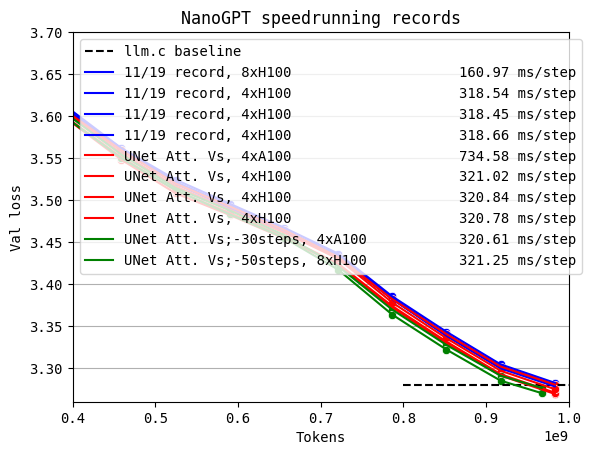

In [12]:
sns.lineplot(x=np.linspace(0.8e9, 1.0e9, 100), y=[3.28]*100, linestyle="--", color="black", label="llm.c baseline")

offset = 0
for i, palette in enumerate(color_palettes):
    n = len(all_filenames[i])

    for idx, (tok, val_loss, step_avg_, label) in enumerate(
        zip(
            train_tokens[offset:offset+n],
            val_losses[offset:offset+n],
            step_avg[offset:offset+n],
            labels[offset:offset+n],
        )
    ):
        sns.scatterplot(x=tok, y=val_loss, linewidth=0.5, color=palette[idx])
        sns.lineplot(x=tok, y=val_loss, label=f"{label:<40}{step_avg_:.2f} ms/step", color=palette[idx])

    offset += n

plt.title("NanoGPT speedrunning records")
plt.legend(loc="upper left")
# plt.ylim(3.26, 3.36)
# plt.yticks(np.linspace(3.26, 3.36, 11))
plt.ylim(3.26, 3.7)
# plt.xlim(1.2e9, 1.6e9)
plt.xlim(0.4e9, 1.0e9)
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("Tokens")
plt.savefig("nanogpt_speedrun.png")

In [13]:
161.84 * 1875, 165 * 1825

(303450.0, 301125)

In [82]:
import sympy as sp

k, s = sp.symbols("k s")

f = (161.84 + k) * (1875 - s) - (161.84 * 1875)
f = sp.simplify(f)
sol = sp.solve(f, s)[0]

sol_np = sp.lambdify((k,), sol)

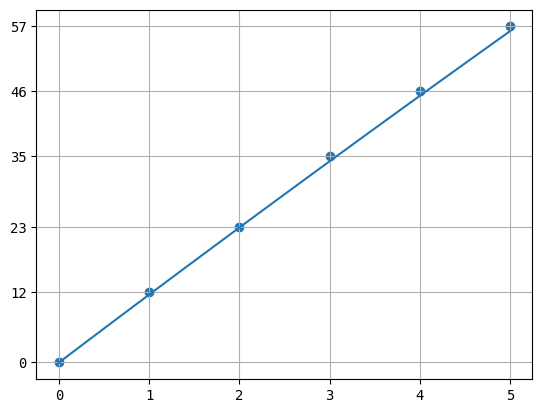

In [84]:
x = np.linspace(0, 5, 100)
x0 = np.linspace(0, 5, 6)
y = sol_np(x)
y0 = np.ceil(sol_np(x0))

plt.scatter(x0, y0)
plt.plot(x, y)
plt.yticks(y0)
plt.grid()